In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Dec 29 08:04:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   40C    P8    40W / 250W |    891MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '29December_Tracks_to_Hists_First_Iteration_10epochs_lr_1em7_2p5_kde2hists_allFloat'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 1e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 27.49 s
outer loop X.shape =  (20000, 9, 600)
Constructing 18000 event dataset took 0.2753 s
x_t.shape =  torch.Size([18000, 9, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  9
x_t.shape =  torch.Size([18000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [12]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '28December_Tracks_to_Hists_FirstTraining_700epochs_lr_1em7_2p5_kde2hists_frozen'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


for model_t2kde_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.weight
index, k =   29    fc1.bias
index, k =   30    finalFil

In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


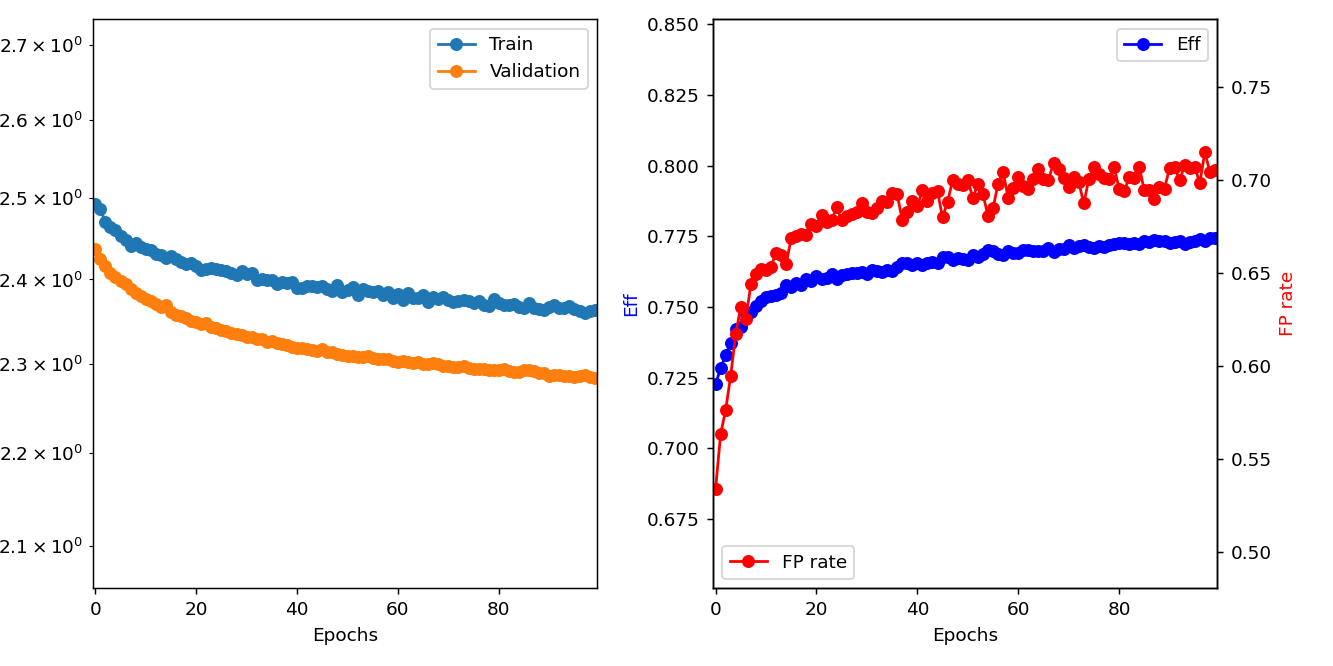

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Epoch 0: train=2.49319, val=2.43693, took 43.83 s
  Validation Found 7820 of 10819, added 1068 (eff 72.28%) (0.534 FP/event)


Epoch 1: train=2.48602, val=2.42521, took 43.904 s
  Validation Found 7880 of 10819, added 1127 (eff 72.83%) (0.563 FP/event)


Epoch 2: train=2.47029, val=2.4162, took 43.629 s
  Validation Found 7930 of 10819, added 1153 (eff 73.30%) (0.576 FP/event)


Epoch 3: train=2.46408, val=2.40832, took 43.671 s
  Validation Found 7978 of 10819, added 1190 (eff 73.74%) (0.595 FP/event)


Epoch 4: train=2.46069, val=2.40299, took 43.579 s
  Validation Found 8031 of 10819, added 1235 (eff 74.23%) (0.617 FP/event)


Epoch 5: train=2.45297, val=2.39866, took 43.586 s
  Validation Found 8040 of 10819, added 1264 (eff 74.31%) (0.632 FP/event)


Epoch 6: train=2.44798, val=2.39482, took 43.778 s
  Validation Found 8089 of 10819, added 1251 (eff 74.77%) (0.625 FP/event)


Epoch 7: train=2.44096, val=2.38839, took 43.636 s
  Validation Found 8096 of 10819, added 1288 (eff 74.83%) (0.644 FP/event)


Epoch 8: train=2.44402, val=2.38425, took 43.713 s
  Validation Found 8118 of 10819, added 1299 (eff 75.03%) (0.649 FP/event)


Epoch 9: train=2.4389, val=2.38037, took 43.885 s
  Validation Found 8136 of 10819, added 1305 (eff 75.20%) (0.652 FP/event)


Epoch 10: train=2.43724, val=2.3764, took 44.01 s
  Validation Found 8152 of 10819, added 1303 (eff 75.35%) (0.651 FP/event)


Epoch 11: train=2.43527, val=2.37408, took 44.142 s
  Validation Found 8155 of 10819, added 1307 (eff 75.38%) (0.653 FP/event)


Epoch 12: train=2.43094, val=2.37078, took 43.749 s
  Validation Found 8160 of 10819, added 1322 (eff 75.42%) (0.661 FP/event)


Epoch 13: train=2.42918, val=2.36717, took 44.063 s
  Validation Found 8167 of 10819, added 1320 (eff 75.49%) (0.66 FP/event)


Epoch 14: train=2.4257, val=2.36892, took 43.913 s
  Validation Found 8198 of 10819, added 1310 (eff 75.77%) (0.655 FP/event)


Epoch 15: train=2.42842, val=2.36108, took 43.729 s
  Validation Found 8191 of 10819, added 1338 (eff 75.71%) (0.669 FP/event)


Epoch 16: train=2.4243, val=2.3582, took 44.191 s
  Validation Found 8205 of 10819, added 1340 (eff 75.84%) (0.67 FP/event)


Epoch 17: train=2.42153, val=2.356, took 43.757 s
  Validation Found 8198 of 10819, added 1342 (eff 75.77%) (0.671 FP/event)


Epoch 18: train=2.41905, val=2.35385, took 43.522 s
  Validation Found 8221 of 10819, added 1341 (eff 75.99%) (0.67 FP/event)


Epoch 19: train=2.4204, val=2.35082, took 43.696 s
  Validation Found 8214 of 10819, added 1353 (eff 75.92%) (0.676 FP/event)


Epoch 20: train=2.41675, val=2.34968, took 43.517 s
  Validation Found 8235 of 10819, added 1351 (eff 76.12%) (0.675 FP/event)


Epoch 21: train=2.41181, val=2.34697, took 43.732 s
  Validation Found 8221 of 10819, added 1363 (eff 75.99%) (0.681 FP/event)


Epoch 22: train=2.41281, val=2.34874, took 43.759 s
  Validation Found 8226 of 10819, added 1355 (eff 76.03%) (0.677 FP/event)


Epoch 23: train=2.4139, val=2.34296, took 43.678 s
  Validation Found 8242 of 10819, added 1357 (eff 76.18%) (0.678 FP/event)


Epoch 24: train=2.41291, val=2.34204, took 43.538 s
  Validation Found 8223 of 10819, added 1371 (eff 76.01%) (0.685 FP/event)


Epoch 25: train=2.4119, val=2.33936, took 43.613 s
  Validation Found 8237 of 10819, added 1357 (eff 76.13%) (0.678 FP/event)


Epoch 26: train=2.41038, val=2.33833, took 43.7 s
  Validation Found 8240 of 10819, added 1361 (eff 76.16%) (0.68 FP/event)


Epoch 27: train=2.40842, val=2.33675, took 43.913 s
  Validation Found 8243 of 10819, added 1364 (eff 76.19%) (0.682 FP/event)


Epoch 28: train=2.4053, val=2.33558, took 43.82 s
  Validation Found 8243 of 10819, added 1366 (eff 76.19%) (0.683 FP/event)


Epoch 29: train=2.41032, val=2.33363, took 43.549 s
  Validation Found 8248 of 10819, added 1376 (eff 76.24%) (0.688 FP/event)


Epoch 30: train=2.40708, val=2.33178, took 43.711 s
  Validation Found 8241 of 10819, added 1366 (eff 76.17%) (0.683 FP/event)


Epoch 31: train=2.40784, val=2.33127, took 43.891 s
  Validation Found 8258 of 10819, added 1365 (eff 76.33%) (0.682 FP/event)


Epoch 32: train=2.39997, val=2.32897, took 43.647 s
  Validation Found 8253 of 10819, added 1370 (eff 76.28%) (0.685 FP/event)


Epoch 33: train=2.40042, val=2.32932, took 43.824 s
  Validation Found 8248 of 10819, added 1378 (eff 76.24%) (0.689 FP/event)


Epoch 34: train=2.39963, val=2.32579, took 43.534 s
  Validation Found 8257 of 10819, added 1377 (eff 76.32%) (0.688 FP/event)


Epoch 35: train=2.39915, val=2.32761, took 43.682 s
  Validation Found 8254 of 10819, added 1386 (eff 76.29%) (0.693 FP/event)


Epoch 36: train=2.39511, val=2.3243, took 43.421 s
  Validation Found 8266 of 10819, added 1385 (eff 76.40%) (0.692 FP/event)


Epoch 37: train=2.39697, val=2.32302, took 43.75 s
  Validation Found 8285 of 10819, added 1357 (eff 76.58%) (0.678 FP/event)


Epoch 38: train=2.39532, val=2.3223, took 43.813 s
  Validation Found 8284 of 10819, added 1366 (eff 76.57%) (0.683 FP/event)


Epoch 39: train=2.39713, val=2.32041, took 43.61 s
  Validation Found 8276 of 10819, added 1378 (eff 76.50%) (0.689 FP/event)


Epoch 40: train=2.39007, val=2.31924, took 43.66 s
  Validation Found 8284 of 10819, added 1372 (eff 76.57%) (0.686 FP/event)


Epoch 41: train=2.39016, val=2.31832, took 43.875 s
  Validation Found 8274 of 10819, added 1389 (eff 76.48%) (0.694 FP/event)


Epoch 42: train=2.39171, val=2.31756, took 43.583 s
  Validation Found 8285 of 10819, added 1378 (eff 76.58%) (0.689 FP/event)


Epoch 43: train=2.39211, val=2.31604, took 43.661 s
  Validation Found 8287 of 10819, added 1386 (eff 76.60%) (0.693 FP/event)


Epoch 44: train=2.39064, val=2.31557, took 43.689 s
  Validation Found 8284 of 10819, added 1388 (eff 76.57%) (0.694 FP/event)


Epoch 45: train=2.39233, val=2.31763, took 43.615 s
  Validation Found 8306 of 10819, added 1360 (eff 76.77%) (0.68 FP/event)


Epoch 46: train=2.38821, val=2.31392, took 43.71 s
  Validation Found 8306 of 10819, added 1377 (eff 76.77%) (0.688 FP/event)


Epoch 47: train=2.38567, val=2.31378, took 43.779 s
  Validation Found 8293 of 10819, added 1400 (eff 76.65%) (0.7 FP/event)


Epoch 48: train=2.39387, val=2.31184, took 43.714 s
  Validation Found 8301 of 10819, added 1396 (eff 76.73%) (0.698 FP/event)


Epoch 49: train=2.38527, val=2.31129, took 43.671 s
  Validation Found 8300 of 10819, added 1395 (eff 76.72%) (0.697 FP/event)


Epoch 50: train=2.38772, val=2.30976, took 43.628 s
  Validation Found 8296 of 10819, added 1400 (eff 76.68%) (0.7 FP/event)


Epoch 51: train=2.39041, val=2.30907, took 43.773 s
  Validation Found 8315 of 10819, added 1381 (eff 76.86%) (0.69 FP/event)


Epoch 52: train=2.38128, val=2.30884, took 44.344 s
  Validation Found 8306 of 10819, added 1396 (eff 76.77%) (0.698 FP/event)


Epoch 53: train=2.38812, val=2.30852, took 43.808 s
  Validation Found 8319 of 10819, added 1385 (eff 76.89%) (0.692 FP/event)


Epoch 54: train=2.38646, val=2.30934, took 43.967 s
  Validation Found 8332 of 10819, added 1362 (eff 77.01%) (0.681 FP/event)


Epoch 55: train=2.38507, val=2.30779, took 43.439 s
  Validation Found 8328 of 10819, added 1370 (eff 76.98%) (0.685 FP/event)


Epoch 56: train=2.38581, val=2.30609, took 43.717 s
  Validation Found 8317 of 10819, added 1396 (eff 76.87%) (0.698 FP/event)


Epoch 57: train=2.38113, val=2.30569, took 43.987 s
  Validation Found 8313 of 10819, added 1409 (eff 76.84%) (0.704 FP/event)


Epoch 58: train=2.38512, val=2.30568, took 44.393 s
  Validation Found 8329 of 10819, added 1381 (eff 76.98%) (0.69 FP/event)


Epoch 59: train=2.37807, val=2.30329, took 43.803 s
  Validation Found 8323 of 10819, added 1392 (eff 76.93%) (0.696 FP/event)


Epoch 60: train=2.38213, val=2.30271, took 43.782 s
  Validation Found 8321 of 10819, added 1403 (eff 76.91%) (0.701 FP/event)


Epoch 61: train=2.37581, val=2.30339, took 43.514 s
  Validation Found 8333 of 10819, added 1394 (eff 77.02%) (0.697 FP/event)


Epoch 62: train=2.38412, val=2.30272, took 43.587 s
  Validation Found 8332 of 10819, added 1391 (eff 77.01%) (0.695 FP/event)


Epoch 63: train=2.37791, val=2.30163, took 43.85 s
  Validation Found 8328 of 10819, added 1401 (eff 76.98%) (0.7 FP/event)


Epoch 64: train=2.37725, val=2.30232, took 43.73 s
  Validation Found 8328 of 10819, added 1412 (eff 76.98%) (0.706 FP/event)


Epoch 65: train=2.38104, val=2.30042, took 44.134 s
  Validation Found 8329 of 10819, added 1401 (eff 76.98%) (0.7 FP/event)


Epoch 66: train=2.37348, val=2.30022, took 43.613 s
  Validation Found 8339 of 10819, added 1400 (eff 77.08%) (0.7 FP/event)


Epoch 67: train=2.37844, val=2.3016, took 43.702 s
  Validation Found 8325 of 10819, added 1419 (eff 76.95%) (0.709 FP/event)


Epoch 68: train=2.37651, val=2.29997, took 43.696 s
  Validation Found 8335 of 10819, added 1412 (eff 77.04%) (0.706 FP/event)


Epoch 69: train=2.3794, val=2.29793, took 44.189 s
  Validation Found 8336 of 10819, added 1402 (eff 77.05%) (0.701 FP/event)


Epoch 70: train=2.37562, val=2.29843, took 43.647 s
  Validation Found 8352 of 10819, added 1393 (eff 77.20%) (0.696 FP/event)


Epoch 71: train=2.37291, val=2.29688, took 43.492 s
  Validation Found 8340 of 10819, added 1403 (eff 77.09%) (0.701 FP/event)


Epoch 72: train=2.37416, val=2.29704, took 43.689 s
  Validation Found 8347 of 10819, added 1398 (eff 77.15%) (0.699 FP/event)


Epoch 73: train=2.37518, val=2.298, took 43.687 s
  Validation Found 8353 of 10819, added 1375 (eff 77.21%) (0.687 FP/event)


Epoch 74: train=2.37413, val=2.29528, took 44.088 s
  Validation Found 8345 of 10819, added 1401 (eff 77.13%) (0.7 FP/event)


Epoch 75: train=2.37224, val=2.29463, took 44.035 s
  Validation Found 8340 of 10819, added 1414 (eff 77.09%) (0.707 FP/event)


Epoch 76: train=2.37465, val=2.29442, took 43.636 s
  Validation Found 8347 of 10819, added 1407 (eff 77.15%) (0.703 FP/event)


Epoch 77: train=2.36919, val=2.29439, took 43.955 s
  Validation Found 8344 of 10819, added 1402 (eff 77.12%) (0.701 FP/event)


Epoch 78: train=2.36876, val=2.2932, took 43.836 s
  Validation Found 8353 of 10819, added 1401 (eff 77.21%) (0.7 FP/event)


Epoch 79: train=2.37628, val=2.29341, took 43.662 s
  Validation Found 8354 of 10819, added 1414 (eff 77.22%) (0.707 FP/event)


Epoch 80: train=2.37212, val=2.2936, took 43.623 s
  Validation Found 8359 of 10819, added 1391 (eff 77.26%) (0.695 FP/event)


Epoch 81: train=2.36943, val=2.29468, took 43.638 s
  Validation Found 8359 of 10819, added 1388 (eff 77.26%) (0.694 FP/event)


Epoch 82: train=2.36993, val=2.29188, took 43.456 s
  Validation Found 8356 of 10819, added 1403 (eff 77.23%) (0.701 FP/event)


Epoch 83: train=2.3704, val=2.2907, took 43.64 s
  Validation Found 8361 of 10819, added 1402 (eff 77.28%) (0.701 FP/event)


Epoch 84: train=2.3671, val=2.29152, took 43.607 s
  Validation Found 8356 of 10819, added 1414 (eff 77.23%) (0.707 FP/event)


Epoch 85: train=2.36576, val=2.29299, took 44.251 s
  Validation Found 8369 of 10819, added 1389 (eff 77.35%) (0.694 FP/event)


Epoch 86: train=2.3714, val=2.29362, took 43.898 s
  Validation Found 8362 of 10819, added 1389 (eff 77.29%) (0.694 FP/event)


Epoch 87: train=2.36644, val=2.29178, took 43.816 s
  Validation Found 8371 of 10819, added 1380 (eff 77.37%) (0.69 FP/event)


Epoch 88: train=2.36491, val=2.2898, took 43.749 s
  Validation Found 8366 of 10819, added 1393 (eff 77.33%) (0.696 FP/event)


Epoch 89: train=2.36317, val=2.28985, took 43.615 s
  Validation Found 8366 of 10819, added 1391 (eff 77.33%) (0.695 FP/event)


Epoch 90: train=2.36702, val=2.28709, took 44.273 s
  Validation Found 8361 of 10819, added 1413 (eff 77.28%) (0.706 FP/event)


Epoch 91: train=2.36891, val=2.28712, took 43.638 s
  Validation Found 8364 of 10819, added 1414 (eff 77.31%) (0.707 FP/event)


Epoch 92: train=2.36545, val=2.28793, took 43.632 s
  Validation Found 8368 of 10819, added 1400 (eff 77.35%) (0.7 FP/event)


Epoch 93: train=2.36633, val=2.28696, took 43.748 s
  Validation Found 8356 of 10819, added 1416 (eff 77.23%) (0.708 FP/event)


Epoch 94: train=2.36882, val=2.28626, took 43.65 s
  Validation Found 8365 of 10819, added 1413 (eff 77.32%) (0.706 FP/event)


Epoch 95: train=2.36522, val=2.28548, took 44.218 s
  Validation Found 8369 of 10819, added 1414 (eff 77.35%) (0.707 FP/event)


Epoch 96: train=2.3618, val=2.28658, took 44.095 s
  Validation Found 8375 of 10819, added 1397 (eff 77.41%) (0.698 FP/event)


Epoch 97: train=2.3596, val=2.2876, took 43.539 s
  Validation Found 8366 of 10819, added 1430 (eff 77.33%) (0.715 FP/event)


Epoch 98: train=2.36285, val=2.28495, took 43.734 s
  Validation Found 8377 of 10819, added 1409 (eff 77.43%) (0.704 FP/event)


Epoch 99: train=2.36361, val=2.28391, took 43.798 s
  Validation Found 8378 of 10819, added 1411 (eff 77.44%) (0.705 FP/event)



In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


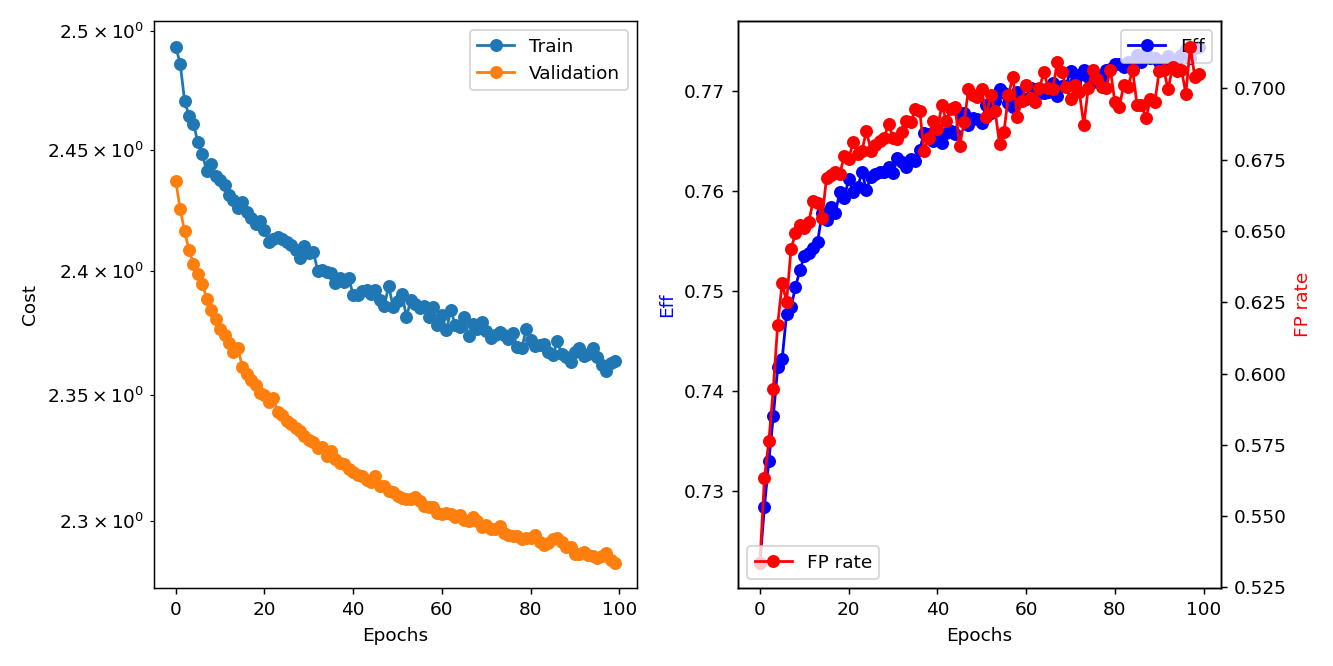

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [20]:
##quit()

